# Setting

In [9]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

class config:
    dataroot = 'data'
    workers = 2
    imageSize = 32
    nc = 3 # input image channels
    nz = 100 # size of the latent z vector
    ngf = 64
    ngpu = 1
    state_E = '../../saved_models/VAE_cifar10/netE_pixel.pth'
    state_G = '../../saved_models/VAE_cifar10/netG_pixel.pth'
    batch_size = 1
    train_batchsize = 1
    num_samples=20
    beta = 1
    maxiter = 10000
opt = config

np.random.seed(1234)
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

# DataLoader

In [10]:
import torch
import DCGAN_VAE_pixel as DVAE
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

netG = DVAE.DCGAN_G(opt.imageSize, opt.nz, opt.nc, opt.ngf, opt.ngpu)

state_G = torch.load(opt.state_G, map_location = device)
netG.load_state_dict(state_G)

netE = DVAE.Encoder(opt.imageSize, opt.nz, opt.nc, opt.ngf, opt.ngpu)
state_E = torch.load(opt.state_E, map_location = device)
netE.load_state_dict(state_E)

netG.to(device)
netE.to(device)
netE.eval()
netG.eval()

DCGAN_G(
  (main): Sequential(
    (initial:100-256:convt): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:256:relu): ReLU(inplace=True)
    (pyramid:256-128:convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:64:relu): ReLU(inplace=True)
    (final:64-3:convt): ConvTranspose2d(64, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)

In [8]:
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import os
import cv2
from PIL import Image

cifar

In [ ]:
dataset_cifar = dset.CIFAR10(root=opt.dataroot, train=False, download=True, transform=transforms.Compose([
                                transforms.Resize((opt.imageSize)),
                                transforms.ToTensor(),
                            ]))
test_loader_cifar = torch.utils.data.DataLoader(dataset_cifar, batch_size=opt.batch_size,
                                            shuffle=False, num_workers=int(opt.workers))

svhn

In [ ]:
dataset_svhn = dset.SVHN(root=opt.dataroot, split='test',  transform=transforms.Compose([
                                transforms.Resize((opt.imageSize,opt.imageSize)),
                                transforms.ToTensor(),
                            ]),download=True)

test_loader_svhn = torch.utils.data.DataLoader(dataset_svhn, batch_size=opt.batch_size,
                                            shuffle=False, num_workers=int(opt.workers))

celeba

In [ ]:
import torch.utils.data as data

class CelebA(data.Dataset):
    def __init__(self, db_path, transform=None):
        super(CelebA, self).__init__()
        self.db_path = db_path
        elements = os.listdir(self.db_path)
        self.total_path = [self.db_path+'/'+element for element in elements]
        self.transform = transform
    def __len__(self):
        return len(self.total_path)
    
    def __getitem__(self, index):
        current_path = self.total_path[index]
        img = cv2.imread(current_path)
        img = Image.fromarray(img)
        img = self.transform(img)
        return img

transform=transforms.Compose([
                                transforms.Resize((opt.imageSize,opt.imageSize)),
                                transforms.ToTensor(),
                            ])

celeba = CelebA('data/celeba/archive', transform = transform)
test_loader_celeba = torch.utils.data.DataLoader(celeba, batch_size=opt.batch_size,
                                            shuffle=False, num_workers=0)


noise

In [ ]:
class Noise(data.Dataset):
    def __init__(self, number=10000, transform=None):
        super(Noise, self).__init__()
        self.transform = transform
        self.number = number
        self.total_data = np.random.randint(0,256, (self.number, 3, 32, 32))
        
    def __len__(self):
        return self.number
    
    def __getitem__(self, index):
        if self.transform is not None:
            return self.transform(self.total_data[index])
        else:
            return np.array(self.total_data[index]/255, dtype='float32')

noise = Noise()
test_loader_noise = torch.utils.data.DataLoader(noise, batch_size=opt.batch_size,
                                               shuffle=False, num_workers=0)

# Loss function

In [5]:
loss_fn = nn.CrossEntropyLoss(reduction = 'none')

def KL_div(mu,logvar,reduction = 'avg'):
    mu = mu.view(mu.size(0),mu.size(1))
    logvar = logvar.view(logvar.size(0), logvar.size(1))
    if reduction == 'sum':
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    else:
        KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),1) 
        return KL

def loss_function(x, kernel_output):
    y, mu, logvar = kernel_output
    b = x.size(0)
    target = Variable(x.data.view(-1) * 255).long()
    y = y.contiguous()
    y = y.view(-1,256)
    recl = loss_fn(y, target)
    recl = torch.sum(recl)/b
    kld = KL_div(mu,logvar)
    return recl+kld.mean()

# Fisher score

cifar

In [12]:
dataset = dset.CIFAR10(root=opt.dataroot, download=True,train = True,
                       transform=transforms.Compose([
                            transforms.Resize((opt.imageSize)),
                           transforms.ToTensor(),
                       ]))
dataloader_cifar = torch.utils.data.DataLoader(dataset, batch_size=opt.train_batchsize,
                                        shuffle=True, num_workers=int(opt.workers))

Files already downloaded and verified


Calculate Fisher Score

In [7]:
from fisherutils import *

In [13]:
dicts = [netG.main[-1].weight,netE.conv1.weight]
Grads, normalize_factor = Calculate_fisher(netE, netG, dataset, dicts, max_iter=10000, num_samples=opt.num_samples, opt=opt)

Observe fisher distribution

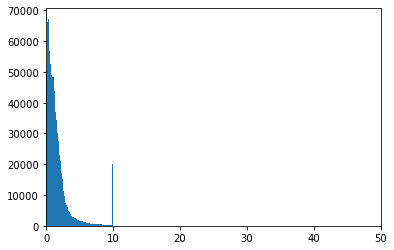

tensor(0.0010)


In [14]:
plt.hist(np.where(Grads.detach().cpu()>10, 10,Grads.detach().cpu()), bins=100)
plt.xlim(0,50)
plt.show()
print(Grads.detach().cpu().min())

Calculate score statistic

In [15]:
cifar_Gradients = Calculate_score(netE, netG, dataset_cifar, dicts, Grads, normalize_factor, 2000, opt.num_samples, opt=opt)

In [16]:
svhn_Gradients = Calculate_score(netE, netG, dataset_svhn, dicts, Grads, normalize_factor, 2000, opt.num_samples, opt=opt)

In [21]:
#celeba_Gradients = Calculate_score(netE, netG, celeba, dicts, Grads, normalize_factor, 2000, opt.num_samples, opt=opt)

In [25]:
#noise_Gradients = Calculate_score(netE, netG, noise, dicts, Grads, normalize_factor, 2000, opt.num_samples, opt=opt)

plot histogram of in-dist vs ood

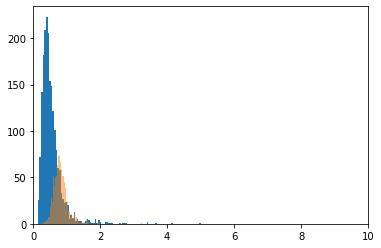

In [19]:
plot_hist(cifar_Gradients, svhn_Gradients)

plot auroc curve

AUC for Gradient Norm is: 0.84872375


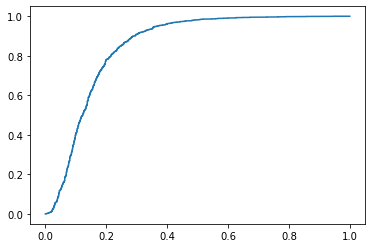

In [17]:
AUROC(cifar_Gradients, svhn_Gradients)